In [89]:
import openmm.app as app
import openmm as mm
import openmm.unit as unit
import numpy as np
import jax
import jax.numpy as jnp
import dmff
from dmff.api.xmlio import XMLIO
from dmff.api.paramset import ParamSet
from dmff.generators.classical import CoulombGenerator, LennardJonesGenerator
from dmff.api.hamiltonian import Hamiltonian
from dmff.operators import ParmedLennardJonesOperator
from dmff import NeighborListFreud
import mdtraj as md
from tqdm import tqdm
import parmed
import sys
import os

In [109]:
prm_top = parmed.load_file("Lig.top")
prm_top_500 = prm_top * 500
dmfftop = dmff.DMFFTopology(from_top=prm_top_500.topology)
prmop = ParmedLennardJonesOperator()
dmfftop = prmop(dmfftop, gmx_top = prm_top_500)

prmop.renderLennardJonesXML("init.xml")
xmlio = XMLIO()
xmlio.loadXML("init.xml")
ffinfo = xmlio.parseXML()
cov_mat = dmfftop.buildCovMat()

paramset = ParamSet()
lj_gen = LennardJonesGenerator(ffinfo, paramset)

In [110]:
lj_force = lj_gen.createPotential(
    dmfftop, nonbondedMethod=app.CutoffPeriodic, nonbondedCutoff=1.0, args={})

### 基于给定拓扑进行采样的函数

In [124]:
def runMD(topfile, pdbfile, trajfile, length):
    try:
        os.remove("Lig_500.top")
    except:
        pass
    top_prm = parmed.load_file(topfile)
    top_500 = top_prm * 500
    top_500.save("Lig_500.top")
    pdb = app.PDBFile(pdbfile)
    top = app.GromacsTopFile("Lig_500.top")
    top.topology.setPeriodicBoxVectors(pdb.topology.getPeriodicBoxVectors())
    system = top.createSystem(nonbondedMethod=app.PME, nonbondedCutoff=1.0*unit.nanometer, constraints=app.HBonds, hydrogenMass=3*unit.dalton)
    for force in system.getForces():
        if isinstance(force, mm.NonbondedForce):
            force.setUseDispersionCorrection(False)
    system.addForce(mm.MonteCarloBarostat(1.0*unit.bar, 300*unit.kelvin, 25))
    integ = mm.LangevinIntegrator(300*unit.kelvin, 1/unit.picosecond, 2.5*unit.femtosecond)
    simulation = app.Simulation(top.topology, system, integ)
    simulation.reporters.append(app.StateDataReporter(sys.stdout, 400, time=True, potentialEnergy=True, temperature=True, density=True, speed=True, remainingTime=True, totalSteps=int(length) * 400))
    simulation.reporters.append(app.DCDReporter(trajfile, 400))
    simulation.context.setPositions(pdb.getPositions())
    simulation.minimizeEnergy(maxIterations=200)
    simulation.step(int(length) * 400)
    os.remove("Lig_500.top")

# runMD("Lig.top", "init.pdb", "traj.dcd", 100)

In [126]:
def rerun_energy(pdb, traj, top, skip=20, removeLJ=True):
    samples = md.load(traj, top=pdb)[skip:]
    try:
        os.remove("Lig_500.top")
    except:
        pass
    top_prm = parmed.load_file(top)
    top_500 = top_prm * 500
    top_500.save("Lig_500.top")
    pdb = app.PDBFile(pdb)
    top = app.GromacsTopFile("Lig_500.top")
    os.remove("Lig_500.top")
    top.topology.setPeriodicBoxVectors(pdb.topology.getPeriodicBoxVectors())
    system = top.createSystem(nonbondedMethod=app.PME, nonbondedCutoff=1.0*unit.nanometer, constraints=app.HBonds, hydrogenMass=3*unit.dalton)
    
    for force in system.getForces():
        if isinstance(force, mm.NonbondedForce):
            force.setUseDispersionCorrection(False)
            if removeLJ:
                for npart in range(force.getNumParticles()):
                    chrg, sig, eps = force.getParticleParameters(npart)
                    force.setParticleParameters(npart, chrg, 1.0, 0.0)
                for nex in range(force.getNumExceptions()):
                    p1, p2, chrg, sig, eps = force.getExceptionParameters(nex)
                    force.setExceptionParameters(nex, p1, p2, chrg, 1.0, 0.0)
    integ = mm.LangevinIntegrator(300*unit.kelvin, 1/unit.picosecond, 2.5*unit.femtosecond)
    ctx = mm.Context(system, integ)
    energies = []
    for frame in tqdm(samples):
        ctx.setPositions(frame.xyz[0] * unit.nanometer)
        ctx.setPeriodicBoxVectors(*frame.unitcell_vectors[0])
        ctx.applyConstraints(1e-10)
        state = ctx.getState(getEnergy=True)
        energy = state.getPotentialEnergy().value_in_unit(unit.kilojoule_per_mole)
        energies.append(energy)
    return np.array(energies)

# rerun_energy("init.pdb", "traj.dcd", "Lig.top")

In [113]:
def rerun_dmff_lennard_jones(params, pdb, traj, efunc, skip=20):
    samples = md.load(traj, top=pdb)[skip:]
    energies = []
    nblist = NeighborListFreud(samples.unitcell_vectors[0], 1.0, cov_mat)
    xyzs_jnp = jnp.array(samples.xyz)
    cell_jnp = jnp.array(samples.unitcell_vectors)
    pairs_prep = []
    for frame in tqdm(samples):
        # calc pair
        pairs = nblist.allocate(frame.xyz[0], frame.unitcell_vectors[0])
        pairs_prep.append(pairs)
    pmax = max([i.shape[0] for i in pairs_prep])
    pairs_jnp = np.zeros((len(pairs_prep), pmax, 3), dtype=int) + frame.xyz.shape[1]
    for n, pairs in enumerate(pairs_prep):
        pairs_jnp[n,:pairs.shape[0],:] = pairs[:,:]
    pairs_jnp = jnp.array(pairs_jnp)
    energies = jax.vmap(efunc, (0, 0, 0, None), 0)(xyzs_jnp, cell_jnp, pairs_jnp, params)
    return energies

In [114]:
pj = rerun_dmff_lennard_jones(paramset, "init.pdb", "traj.dcd", lj_force)

100%|██████████| 80/80 [00:18<00:00,  4.44it/s]


In [115]:
pj

Array([-10259.282 , -10072.819 , -10270.184 , -10181.286 ,  -9871.413 ,
       -10087.422 ,  -9923.77  , -10097.987 , -10111.795 , -10059.525 ,
       -10106.235 , -10029.404 ,  -9918.766 , -10203.414 , -10095.917 ,
       -10050.951 , -10190.898 , -10272.999 , -10262.374 , -10232.128 ,
       -10238.684 , -10028.451 ,  -9884.382 ,  -9966.482 ,  -9937.881 ,
        -9964.069 ,  -9998.268 , -10018.248 ,  -9835.656 ,  -9992.064 ,
        -9802.05  ,  -9841.151 ,  -9855.98  , -10082.376 ,  -9958.59  ,
        -9949.369 , -10299.512 , -10282.863 , -10156.918 , -10131.67  ,
       -10031.213 , -10060.882 , -10142.455 , -10116.625 , -10166.098 ,
        -9992.108 , -10100.144 , -10295.543 ,  -9991.143 , -10293.24  ,
       -10068.669 , -10131.208 ,  -9841.764 , -10132.465 ,  -9901.182 ,
       -10209.082 ,  -9997.776 , -10121.98  ,  -9842.379 , -10071.485 ,
       -10180.456 , -10278.77  , -10157.969 , -10045.396 , -10144.507 ,
        -9809.929 , -10058.0625,  -9986.914 , -10069.897 , -1003

In [127]:
ener = rerun_energy("init.pdb", "traj.dcd", "Lig.top", removeLJ=False)
ener_no_lj = rerun_energy("init.pdb", "traj.dcd", "Lig.top")

100%|██████████| 80/80 [00:02<00:00, 26.94it/s]


In [128]:
ener - ener_no_lj

array([-10259.2890625, -10072.8359375, -10270.1953125, -10181.296875 ,
        -9871.421875 , -10087.421875 ,  -9923.78125  , -10097.9921875,
       -10111.796875 , -10059.53125  , -10106.2421875, -10029.4140625,
        -9918.7734375, -10203.421875 , -10095.9296875, -10050.96875  ,
       -10190.9140625, -10273.0078125, -10262.3828125, -10232.140625 ,
       -10238.6953125, -10028.46875  ,  -9884.3984375,  -9966.4921875,
        -9937.890625 ,  -9964.0703125,  -9998.2734375, -10018.25     ,
        -9835.6640625,  -9992.0703125,  -9802.0625   ,  -9841.15625  ,
        -9855.9921875, -10082.3828125,  -9958.59375  ,  -9949.375    ,
       -10299.515625 , -10282.8671875, -10156.921875 , -10131.671875 ,
       -10031.21875  , -10060.890625 , -10142.4609375, -10116.6328125,
       -10166.1171875,  -9992.1171875, -10100.15625  , -10295.5546875,
        -9991.15625  , -10293.25     , -10068.6796875, -10131.2265625,
        -9841.78125  , -10132.46875  ,  -9901.203125 , -10209.09375  ,
      

In [116]:
import matplotlib.pyplot as plt

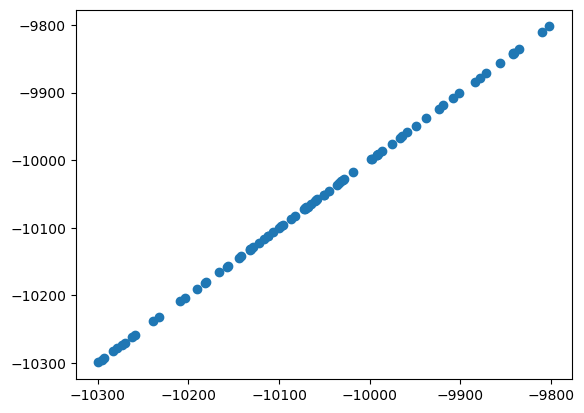

In [129]:
plt.scatter(pj, ener - ener_no_lj)

In [130]:
e_jax = ener_no_lj + pj

In [133]:
e_jax

Array([19819.008, 20110.86 , 19405.441, 19673.855, 20351.719, 20175.602,
       20405.246, 20314.395, 19954.354, 20528.748, 19727.969, 20113.94 ,
       20344.86 , 19843.438, 19785.48 , 19814.088, 19520.555, 20107.828,
       19944.43 , 19767.191, 19880.113, 19682.729, 19586.5  , 19643.62 ,
       20290.502, 19951.453, 19752.842, 19897.041, 19992.219, 20240.81 ,
       19604.613, 20423.387, 20127.941, 20299.328, 20108.012, 19717.209,
       19710.066, 19974.207, 20092.324, 20134.768, 19587.686, 19859.633,
       20126.67 , 19870.586, 19902.098, 19828.367, 19612.55 , 19614.3  ,
       19892.256, 19441.377, 19869.098, 19994.371, 20008.768, 19838.074,
       19210.967, 19640.098, 19408.574, 19761.902, 20360.27 , 20238.086,
       20085.684, 19682.863, 19871.71 , 20335.26 , 20006.047, 19499.406,
       19576.523, 19337.969, 19196.64 , 20252.121, 20399.633, 19358.611,
       19423.424, 19959.525, 20285.152, 19381.604, 19713.453, 19861.193,
       19662.58 , 19821.496], dtype=float32)